# Coursework Template

**Dependencies and imports**

This can take a minute...

In [18]:
# !pip install swig
# !pip install --upgrade rldurham

In [19]:
import torch
import rldurham as rld

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
import copy

**Reinforcement learning agent**

Replace this with your own agent, I recommend starting with TD3 (lecture 8).

In [20]:
class Agent(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Agent, self).__init__()
        
        # Initialize networks with orthogonal weights for better gradient flow
        self.policy = self._build_policy_network(state_dim, action_dim, hidden_dim)
        self.value = self._build_value_network(state_dim, hidden_dim)
        
        # Hyperparameters tuned for stability
        self.gamma = 0.99
        self.learning_rate = 3e-4 #4e-4 was good
        self.gae_lambda = 0.95
        self.clip_ratio = 0.2
        self.entropy_coef = 0.01  # Encourage exploration
        self.value_coef = 0.5    # Balance value and policy learning
        
        # Adaptive noise control
        self.init_action_std = 0.6
        self.action_std = self.init_action_std
        self.action_std_decay = 0.999
        self.min_action_std = 0.2
        self.noise_decay_start = 1000  # Start decay after 100 episodes # 500 was good
        
        # Experience management
        self.trajectory = []
        self.experience_buffer = []  # Store successful episodes
        self.buffer_size = 10000     # Maximum buffer size
        self.success_threshold = 50  # Threshold to consider an episode "successful"
        self.replay_ratio = 0.3  
        
        self.value_normalizer = RunningMeanStd()
        self.state_normalizer = RunningMeanStd(shape=state_dim)
        self.reward_normalizer = RunningMeanStd()
        
        # Optimization
        self.policy_optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.value_optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        self.snapshot_interval = 100  # Save model snapshot every N episodes
        self.snapshots = []
        self.max_snapshots = 3
        self.snapshot_weights = [0.7, 0.2, 0.1]  # Weights for ensemble predictions
        
        # Statistics tracking
        self.running_rewards = deque(maxlen=100)
        self.early_stopping_patience = 50
        self.patience_counter = 0
        self.episode_count = 0
        self.best_reward = float('-inf')
        self.best_avg_reward = float('-inf')
        self.recent_actions = deque(maxlen=5)  # For action smoothing
        
    def _build_policy_network(self, state_dim, action_dim, hidden_dim):
        """Build policy network with proper initialization"""
        policy = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh()
        )
        
        # Orthogonal initialization for better training dynamics
        for layer in policy:
            if isinstance(layer, nn.Linear):
                torch.nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
                torch.nn.init.zeros_(layer.bias)
        
        return policy
    
    def _build_value_network(self, state_dim, hidden_dim):
        """Build value network with proper initialization"""
        value = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        for layer in value:
            if isinstance(layer, nn.Linear):
                torch.nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
                torch.nn.init.zeros_(layer.bias)
        
        return value
    
    def normalize_state(self, state):
        """Normalize state using running statistics"""
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state)
        return torch.FloatTensor(self.state_normalizer(state.numpy()))
    
    def normalize_reward(self, reward):
        """Normalize rewards for more stable learning"""
        self.reward_normalizer(np.array([reward]))
        return reward
    
    def sample_action(self, state, deterministic=False):
        """Sample action with adaptive noise and temporal smoothing"""
        state = self.normalize_state(state)
        
        with torch.no_grad():
            mean_action = self.policy(state)
            
            if deterministic:
                action = mean_action
            else:
                # Add exploration noise with adaptive standard deviation
                noise = torch.randn_like(mean_action) * self.action_std
                action = torch.clamp(mean_action + noise, -1, 1)
                
                # Apply temporal smoothing for more natural movements
                if len(self.recent_actions) > 0:
                    smooth_factor = 0.7
                    prev_action = np.mean([a for a in self.recent_actions], axis=0)
                    action = smooth_factor * action + (1 - smooth_factor) * torch.FloatTensor(prev_action)
                
                # Ensemble prediction from snapshots for more robustness
                if len(self.snapshots) > 0 and np.random.random() < 0.3:  # 30% chance to use ensemble
                    ensemble_actions = [snapshot_policy(state) for snapshot_policy, _ in self.snapshots]
                    ensemble_actions.append(action)  # Include current policy
                    
                    # Weight the actions based on recency
                    weights = self.snapshot_weights[:len(self.snapshots)] + [1.0]
                    weights = [w/sum(weights) for w in weights]
                    
                    action = sum(w * a for w, a in zip(weights, ensemble_actions))
                    action = torch.clamp(action, -1, 1)
            
            self.recent_actions.append(action.numpy())
        
        return action.numpy()
    
    def put_data(self, state, action, reward, next_state, done):
        """Store transition with normalized states"""
        state = self.normalize_state(state)
        next_state = self.normalize_state(next_state)
        norm_reward = self.normalize_reward(reward)
        self.trajectory.append((state, action, norm_reward, next_state, done))
    
    def add_to_experience_buffer(self, episode_data, episode_reward):
        """Add successful episodes to the experience buffer"""
        if episode_reward > self.success_threshold:
            self.experience_buffer.extend(episode_data)
            # Trim buffer if it gets too large
            if len(self.experience_buffer) > self.buffer_size:
                excess = len(self.experience_buffer) - self.buffer_size
                self.experience_buffer = self.experience_buffer[excess:]
    
    def train(self):
        """Update policy and value networks with improved stability measures"""
        if len(self.trajectory) < 1:
            return 0, 0
        
        # Check if we should add the trajectory to the experience buffer
        episode_reward = sum([r for _, _, r, _, _ in self.trajectory])
        self.add_to_experience_buffer(self.trajectory, episode_reward)
        
        # Mix in some past successful experiences if available
        if len(self.experience_buffer) > 0 and np.random.random() < self.replay_ratio:
            replay_size = min(len(self.experience_buffer), int(len(self.trajectory) * 0.5))
            replay_samples = random.sample(self.experience_buffer, replay_size)
            training_data = self.trajectory + replay_samples
        else:
            training_data = self.trajectory
        
        states, actions, rewards, next_states, dones = zip(*training_data)
        
        # Convert to tensors
        states = torch.stack(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.stack(next_states)
        dones = torch.FloatTensor(dones)
        
        # Compute normalized returns and advantages
        with torch.no_grad():
            values = self.value(states).squeeze()
            next_values = self.value(next_states).squeeze()
            
            # Compute GAE
            advantages = torch.zeros_like(rewards)
            gae = 0
            for t in reversed(range(len(rewards))):
                if t == len(rewards) - 1:
                    next_value = next_values[t]
                else:
                    next_value = values[t + 1]
                
                delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
                gae = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * gae
                advantages[t] = gae
            
            returns = advantages + values
            
            # Normalize advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Compute action probabilities
        mean_actions = self.policy(states)
        dist = torch.distributions.Normal(mean_actions, self.action_std)
        old_log_probs = dist.log_prob(actions).sum(dim=1)
        
        # Multiple epochs of optimization with early stopping
        policy_losses = []
        value_losses = []
        kl_divs = []
        
        for epoch in range(10):  # 10 epochs max
            # Compute new action probabilities
            mean_actions = self.policy(states)
            dist = torch.distributions.Normal(mean_actions, self.action_std)
            new_log_probs = dist.log_prob(actions).sum(dim=1)
            
            # Compute entropy for exploration
            entropy = dist.entropy().mean()
            
            # Compute policy loss with clipping
            ratio = torch.exp(new_log_probs - old_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Compute value loss with clipping
            value_pred = self.value(states).squeeze()
            value_clipped = values + torch.clamp(value_pred - values, -self.clip_ratio, self.clip_ratio)
            value_loss_1 = F.mse_loss(value_pred, returns.detach())
            value_loss_2 = F.mse_loss(value_clipped, returns.detach())
            value_loss = torch.max(value_loss_1, value_loss_2)
            
            # Compute KL divergence for early stopping
            approx_kl = ((old_log_probs - new_log_probs) * ratio).mean().item()
            kl_divs.append(approx_kl)
            
            # Store losses
            policy_losses.append(policy_loss.item())
            value_losses.append(value_loss.item())
            
            # Early stopping based on KL divergence
            if approx_kl > 0.015:
                break
                
            # Update policy network
            self.policy_optimizer.zero_grad()
            policy_loss_with_entropy = policy_loss - self.entropy_coef * entropy
            policy_loss_with_entropy.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=0.5)
            self.policy_optimizer.step()
            
            # Update value network separately for more stability
            self.value_optimizer.zero_grad()
            (self.value_coef * value_loss).backward()
            torch.nn.utils.clip_grad_norm_(self.value.parameters(), max_norm=0.5)
            self.value_optimizer.step()
        
        # Clear trajectory buffer
        self.trajectory = []
        
        # Update exploration noise
        if self.episode_count > self.noise_decay_start:
            self.action_std = max(self.min_action_std, 
                                self.action_std * self.action_std_decay)
        
        return np.mean(policy_losses), np.mean(value_losses)
    
    def update_stats(self, episode_reward):
        """Update running statistics and episode count"""
        self.running_rewards.append(episode_reward)
        self.episode_count += 1
        self.best_reward = max(self.best_reward, episode_reward)
        
        # Early stopping check
        current_avg_reward = self.get_average_reward()
        if current_avg_reward > self.best_avg_reward:
            self.best_avg_reward = current_avg_reward
            self.patience_counter = 0
            
            # Save model snapshot for ensemble
            if self.episode_count % self.snapshot_interval == 0:
                policy_copy = copy.deepcopy(self.policy)
                value_copy = copy.deepcopy(self.value)
                self.snapshots.append((policy_copy, value_copy))
                if len(self.snapshots) > self.max_snapshots:
                    self.snapshots.pop(0)  # Remove oldest snapshot
        else:
            self.patience_counter += 1
            
            # If patience exceeded, revert to best snapshot
            if self.patience_counter >= self.early_stopping_patience and len(self.snapshots) > 0:
                print(f"Performance plateaued for {self.early_stopping_patience} episodes. Reverting to previous best model.")
                latest_snapshot = self.snapshots[-1]
                self.policy = copy.deepcopy(latest_snapshot[0])
                self.value = copy.deepcopy(latest_snapshot[1])
                self.patience_counter = 0
    
    def get_average_reward(self):
        """Calculate average reward over last 100 episodes"""
        return np.mean(self.running_rewards) if self.running_rewards else 0
    
    def reset(self):
        """Reset temporal smoothing between episodes"""
        self.recent_actions.clear()
        
    def save(self, filename):
        """
        Save model state with enhanced security and compatibility.
        This version handles separate optimizers for policy and value networks.
        """
        # Save neural network states and their optimizers separately
        network_state = {
            'policy_state_dict': self.policy.state_dict(),
            'value_state_dict': self.value.state_dict(),
            'policy_optimizer_state_dict': self.policy_optimizer.state_dict(),
            'value_optimizer_state_dict': self.value_optimizer.state_dict(),
        }
        torch.save(network_state, filename + '_networks.pt')
        
        # Save normalizer statistics as plain numbers
        normalizer_state = {
            'state_mean': self.state_normalizer.mean.tolist(),
            'state_var': self.state_normalizer.var.tolist(),
            'state_count': float(self.state_normalizer.count),
            'value_mean': self.value_normalizer.mean.tolist(),
            'value_var': self.value_normalizer.var.tolist(),
            'value_count': float(self.value_normalizer.count),
        }
        
        # Save other parameters
        other_state = {
            'episode_count': self.episode_count,
            'best_reward': float(self.best_reward),
            'action_std': float(self.action_std),
            'normalizer_state': normalizer_state
        }
        
        # Save as JSON for better compatibility
        with open(filename + '_other.json', 'w') as f:
            json.dump(other_state, f)

    def load(self, filename):
        """
        Load model state with enhanced security and compatibility.
        This version handles separate optimizers for policy and value networks.
        """
        # Load neural network states
        network_state = torch.load(filename + '_networks.pt', weights_only=True)
        self.policy.load_state_dict(network_state['policy_state_dict'])
        self.value.load_state_dict(network_state['value_state_dict'])
        self.policy_optimizer.load_state_dict(network_state['policy_optimizer_state_dict'])
        self.value_optimizer.load_state_dict(network_state['value_optimizer_state_dict'])
        
        # Load other parameters from JSON
        try:
            with open(filename + '_other.json', 'r') as f:
                other_state = json.load(f)
                
            # Restore normalizer states
            normalizer_state = other_state['normalizer_state']
            
            # Reconstruct state normalizer
            self.state_normalizer.mean = np.array(normalizer_state['state_mean'], dtype=np.float32)
            self.state_normalizer.var = np.array(normalizer_state['state_var'], dtype=np.float32)
            self.state_normalizer.count = normalizer_state['state_count']
            
            # Reconstruct value normalizer
            self.value_normalizer.mean = np.array(normalizer_state['value_mean'], dtype=np.float32)
            self.value_normalizer.var = np.array(normalizer_state['value_var'], dtype=np.float32)
            self.value_normalizer.count = normalizer_state['value_count']
            
            # Restore other parameters
            self.episode_count = other_state['episode_count']
            self.best_reward = other_state['best_reward']
            self.action_std = other_state['action_std']
            
        except (FileNotFoundError, json.JSONDecodeError) as e:
            print(f"Warning: Could not load complete state. Only network weights were restored. Error: {e}")

class RunningMeanStd:
    """Tracks running mean and standard deviation for normalization"""
    def __init__(self, shape=(), epsilon=1e-4):
        self.mean = np.zeros(shape, dtype=np.float32)
        self.var = np.ones(shape, dtype=np.float32)
        self.count = epsilon
        
    def __call__(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0] if len(x.shape) > 1 else 1
        
        delta = batch_mean - self.mean
        self.mean += delta * batch_count / (self.count + batch_count)
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        self.var = M2 / (self.count + batch_count)
        self.count += batch_count
        
        return (x - self.mean) / np.sqrt(self.var + 1e-8)

**Prepare the environment and wrap it to capture statistics, logs, and videos**

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


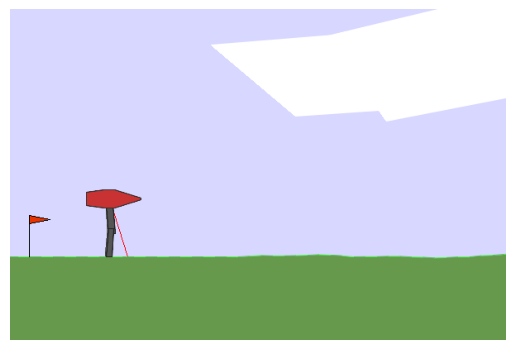

In [21]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

In [22]:
# # in the submission please use seed_everything with seed 42 for verification
# seed, observation, info = rld.seed_everything(42, env)

# # initialise agent
# agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
# max_episodes = 20000
# max_timesteps = 2000

# # track statistics for plotting
# tracker = rld.InfoTracker()

# # switch video recording off (only switch on every x episodes as this is slow)
# env.video = False

# for episode in range(max_episodes):
#     # Set up episode
#     env.info = episode % 10 == 0
#     env.video = episode % 10 == 0
#     current_observation, info = env.reset()
#     episode_reward = 0
    
#     # Reset agent's temporal smoothing
#     agent.reset()
    
#     # Run episode
#     for t in range(max_timesteps):
#         # Get action from agent
#         action = agent.sample_action(current_observation)
        
#         # Take step in environment
#         next_observation, reward, terminated, truncated, info = env.step(action)
        
#         # Store transition and update episode reward
#         agent.put_data(current_observation, action, reward, next_observation, 
#                       terminated or truncated)
#         episode_reward += reward
        
#         # Update observation
#         current_observation = next_observation
        
#         # Check if episode is done
#         if terminated or truncated:
#             break
    
#     # Train agent and update statistics
#     policy_loss, value_loss = agent.train()
#     agent.update_stats(episode_reward)
    
#     # Print progress every 10 episodes
#     if episode % 10 == 0:
#         avg_reward = agent.get_average_reward()
#         print(f"Episode {episode+1}, Reward: {episode_reward:.2f}, "
#               f"Avg Reward: {avg_reward:.2f}, "
#               f"Action STD: {agent.action_std:.3f}")
    
#     # Track and plot
#     tracker.track(info)
#     if (episode + 1) % 10 == 0:
#         tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

# env.close()

# # Write log file
# env.write_log(folder="logs", file="xxxx00-agent-log.txt")

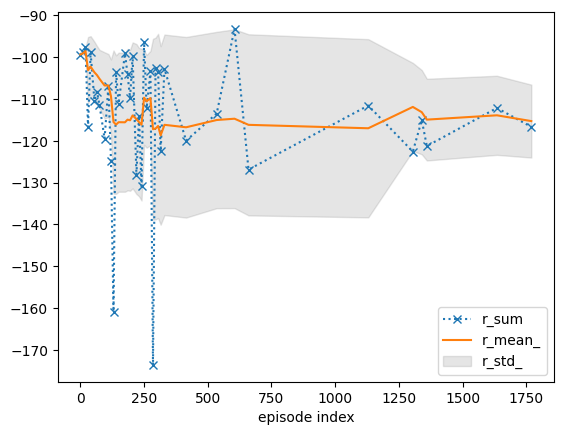

Episode 2331/20000, Reward: -10.85, Avg Reward: 162.26, Action STD: 0.200, Episode Length: 2000, Time: 3114.0s, Est. Remaining: 393.4min
Performance plateaued for 50 episodes. Reverting to previous best model.
Early stopping triggered after 2338 episodes
Loading best model with avg reward: 176.25
Training completed in 52.04 minutes
Best average reward: 176.25
Running final evaluation...


In [ ]:
# in the submission please use seed_everything with seed 42 for verification
import os
import time
import json
import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

# Ensure reproducibility across runs
seed, observation, info = rld.seed_everything(42, env)

# Initialize agent
agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
max_episodes = 20000
max_timesteps = 2000

# Track statistics for plotting with enhanced metrics
tracker = rld.InfoTracker()
evaluation_interval = 50  # Evaluate agent without exploration every N episodes
checkpoint_interval = 500  # Save model checkpoint every N episodes
early_stop_patience = 200  # Episodes to wait before early stopping
best_avg_reward = float('-inf')
patience_counter = 0
min_episodes_before_early_stop = 1000  # Minimum training episodes before considering early stopping

# Create directories for checkpoints and metrics
checkpoint_dir = "checkpoints"
metrics_dir = "metrics"
plots_dir = os.path.join(metrics_dir, "plots")
csv_dir = os.path.join(metrics_dir, "csv")
video_dir = os.path.join(metrics_dir, "videos")

# Create all necessary directories
for directory in [checkpoint_dir, metrics_dir, plots_dir, csv_dir, video_dir]:
    os.makedirs(directory, exist_ok=True)

# Configure video path if the environment supports it
try:
    env.set_video_path(video_dir)
except:
    print(f"Environment doesn't support custom video paths. Videos may be saved elsewhere.")

# Initialize training metrics tracking
training_stats = {
    'episode_rewards': [],
    'avg_rewards': [],
    'policy_losses': [],
    'value_losses': [],
    'episode_lengths': [],
    'learning_rates': []
}

# Vectorize environment operations if possible
# Note: This is a placeholder - actual implementation depends on the env type
try:
    env = rld.make_env_faster(env)  # Fictional function - replace with actual vectorization if available
except:
    print("Environment vectorization not available, using standard environment")

# Learning rate scheduler for gradual LR reduction
initial_lr = agent.learning_rate
min_lr = initial_lr / 10
lr_decay_factor = 0.995
lr_decay_start = 1000

# Start training timer
start_time = time.time()

for episode in range(max_episodes):
    # Set up episode - only record video occasionally to save time
    is_evaluation_episode = episode % evaluation_interval == 0
    env.info = episode % 10 == 0
    env.video = episode % 100 == 0  # Reduced frequency for video recording
    
    current_observation, info = env.reset()
    episode_reward = 0
    episode_start_time = time.time()
    
    # Reset agent's temporal smoothing
    agent.reset()
    
    # Store transitions for batch processing
    episode_transitions = []
    
    # Run episode
    for t in range(max_timesteps):
        # Get action from agent (deterministic for evaluation episodes)
        action = agent.sample_action(current_observation, deterministic=is_evaluation_episode)
        
        # Take step in environment
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        # Store transition
        if not is_evaluation_episode:  # Don't store evaluation episodes
            agent.put_data(current_observation, action, reward, next_observation, 
                          terminated or truncated)
        
        episode_reward += reward
        episode_transitions.append((current_observation, action, reward, next_observation, 
                                   terminated or truncated))
        
        # Update observation
        current_observation = next_observation
        
        # Check if episode is done
        if terminated or truncated:
            break
    
    # Only update the agent if this wasn't an evaluation episode
    if not is_evaluation_episode:
        # Update learning rate according to schedule
        if episode > lr_decay_start:
            new_lr = max(min_lr, initial_lr * (lr_decay_factor ** (episode - lr_decay_start)))
            for param_group in agent.policy_optimizer.param_groups:
                param_group['lr'] = new_lr
            for param_group in agent.value_optimizer.param_groups:
                param_group['lr'] = new_lr
            agent.learning_rate = new_lr
            
        # Train agent in batches (more efficient)
        policy_loss, value_loss = agent.train()
    else:
        policy_loss, value_loss = 0, 0  # No training during evaluation
    
    # Update agent statistics
    agent.update_stats(episode_reward)
    
    # Save metrics
    episode_length = t + 1
    training_stats['episode_rewards'].append(episode_reward)
    training_stats['avg_rewards'].append(agent.get_average_reward())
    training_stats['policy_losses'].append(policy_loss)
    training_stats['value_losses'].append(value_loss)
    training_stats['episode_lengths'].append(episode_length)
    training_stats['learning_rates'].append(agent.learning_rate)
    
    # Save metrics to CSV after each episode
    if episode == 0:
        # Create CSV files with headers
        metrics_files = {
            'rewards': os.path.join(csv_dir, 'episode_rewards.csv'),
            'avg_rewards': os.path.join(csv_dir, 'avg_rewards.csv'),
            'losses': os.path.join(csv_dir, 'losses.csv'),
            'episode_data': os.path.join(csv_dir, 'episode_data.csv')
        }
        
        # Initialize CSV files with headers
        with open(metrics_files['rewards'], 'w') as f:
            f.write('episode,reward\n')
        
        with open(metrics_files['avg_rewards'], 'w') as f:
            f.write('episode,avg_reward_last_100\n')
            
        with open(metrics_files['losses'], 'w') as f:
            f.write('episode,policy_loss,value_loss\n')
            
        with open(metrics_files['episode_data'], 'w') as f:
            f.write('episode,length,learning_rate,action_std\n')
    
    # Append data to CSV files
    with open(os.path.join(csv_dir, 'episode_rewards.csv'), 'a') as f:
        f.write(f"{episode},{episode_reward}\n")
        
    with open(os.path.join(csv_dir, 'avg_rewards.csv'), 'a') as f:
        f.write(f"{episode},{agent.get_average_reward()}\n")
        
    with open(os.path.join(csv_dir, 'losses.csv'), 'a') as f:
        f.write(f"{episode},{policy_loss},{value_loss}\n")
        
    with open(os.path.join(csv_dir, 'episode_data.csv'), 'a') as f:
        f.write(f"{episode},{episode_length},{agent.learning_rate},{agent.action_std}\n")
    
    # Print progress with more detailed information
    if episode % 10 == 0:
        avg_reward = agent.get_average_reward()
        elapsed_time = time.time() - start_time
        eps_per_second = (episode + 1) / elapsed_time if elapsed_time > 0 else 0
        estimated_remaining = (max_episodes - episode - 1) / eps_per_second / 60 if eps_per_second > 0 else 0
        
        print(f"Episode {episode+1}/{max_episodes}, Reward: {episode_reward:.2f}, "
              f"Avg Reward: {avg_reward:.2f}, Action STD: {agent.action_std:.3f}, "
              f"Episode Length: {episode_length}, Time: {elapsed_time:.1f}s, "
              f"Est. Remaining: {estimated_remaining:.1f}min")
    
    # Track and plot
    tracker.track(info)
    if (episode + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))
        
        # Add additional plots for training metrics
        # Create plot filename with timestamp for easier organization
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        plot_filename = os.path.join(plots_dir, f"metrics_ep{episode+1}_{timestamp}.png")
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 3, 1)
        plt.plot(training_stats['episode_rewards'][-100:])
        plt.title('Recent Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 3, 2)
        plt.plot(training_stats['policy_losses'][-100:], label='Policy Loss')
        plt.plot(training_stats['value_losses'][-100:], label='Value Loss')
        plt.title('Losses')
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 3, 3)
        plt.plot(training_stats['episode_lengths'][-100:])
        plt.title('Episode Lengths')
        plt.xlabel('Episode')
        plt.ylabel('Steps')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 3, 4)
        plt.plot(training_stats['learning_rates'])
        plt.title('Learning Rate')
        plt.xlabel('Episode')
        plt.ylabel('LR')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 3, 5)
        # Moving average of rewards for smoothed trend
        window_size = min(25, len(training_stats['episode_rewards']))
        if window_size > 1:
            smoothed_rewards = np.convolve(
                training_stats['episode_rewards'], 
                np.ones(window_size)/window_size, 
                mode='valid'
            )
            plt.plot(smoothed_rewards)
            plt.title(f'Smoothed Rewards (window={window_size})')
            plt.xlabel('Episode')
            plt.ylabel('Smoothed Reward')
            plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 3, 6)
        # Compare action standard deviation with episode rewards
        recent_episodes = min(100, len(training_stats['episode_rewards']))
        if recent_episodes > 0:
            episodes_x = list(range(len(training_stats['episode_rewards'])))[-recent_episodes:]
            ax1 = plt.gca()
            ax1.set_xlabel('Episode')
            ax1.set_ylabel('Reward', color='tab:blue')
            ax1.plot(episodes_x, training_stats['episode_rewards'][-recent_episodes:], color='tab:blue')
            ax1.tick_params(axis='y', labelcolor='tab:blue')
            ax1.grid(True, alpha=0.3)
            
            # Create second y-axis for action std
            ax2 = ax1.twinx()
            ax2.set_ylabel('Action STD', color='tab:red')
            ax2.plot([agent.action_std] * recent_episodes, color='tab:red', linestyle='--')
            ax2.tick_params(axis='y', labelcolor='tab:red')
            plt.title('Reward vs. Exploration (Action STD)')
        
        plt.tight_layout()
        plt.savefig(plot_filename, dpi=300)  # Higher DPI for better quality
        
        # Also save a copy as the "latest" plot for easy access
        plt.savefig(os.path.join(plots_dir, f"latest_metrics.png"), dpi=300)
        plt.close()
    
    # Save checkpoint
    if (episode + 1) % checkpoint_interval == 0 or episode == max_episodes - 1:
        checkpoint_path = os.path.join(checkpoint_dir, f"agent_checkpoint_ep{episode+1}")
        agent.save(checkpoint_path)
        print(f"Checkpoint saved at episode {episode+1}")
    
    # Early stopping check
    curr_avg_reward = agent.get_average_reward()
    if episode > min_episodes_before_early_stop:
        if curr_avg_reward > best_avg_reward:
            best_avg_reward = curr_avg_reward
            patience_counter = 0
            # Save best model
            best_model_path = os.path.join(checkpoint_dir, "agent_best")
            agent.save(best_model_path)
            print(f"New best model saved with avg reward: {best_avg_reward:.2f}")
        else:
            patience_counter += 1
            
        # Check if we should stop early
        if patience_counter >= early_stop_patience:
            print(f"Early stopping triggered after {episode+1} episodes")
            print(f"Loading best model with avg reward: {best_avg_reward:.2f}")
            agent.load(best_model_path)
            break
    
    # Periodically run evaluation with no exploration
    if (episode + 1) % evaluation_interval == 0:
        print(f"Running evaluation at episode {episode+1}...")
        eval_rewards = []
        
        # Run multiple evaluation episodes
        for eval_ep in range(5):
            eval_obs, _ = env.reset()
            eval_reward = 0
            agent.reset()
            
            for _ in range(max_timesteps):
                eval_action = agent.sample_action(eval_obs, deterministic=True)
                eval_obs, eval_r, eval_term, eval_trunc, _ = env.step(eval_action)
                eval_reward += eval_r
                
                if eval_term or eval_trunc:
                    break
                    
            eval_rewards.append(eval_reward)
        
        avg_eval_reward = np.mean(eval_rewards)
        print(f"Evaluation complete - Avg reward over 5 episodes: {avg_eval_reward:.2f}")

# End of training
total_time = time.time() - start_time
print(f"Training completed in {total_time/60:.2f} minutes")
print(f"Best average reward: {best_avg_reward:.2f}")

# Final evaluation
print("Running final evaluation...")
final_eval_rewards = []
env.video = True  # Record final evaluation

for eval_ep in range(10):
    eval_obs, _ = env.reset()
    eval_reward = 0
    agent.reset()
    
    for _ in range(max_timesteps):
        eval_action = agent.sample_action(eval_obs, deterministic=True)
        eval_obs, eval_r, eval_term, eval_trunc, _ = env.step(eval_action)
        eval_reward += eval_r
        
        if eval_term or eval_trunc:
            break
            
    final_eval_rewards.append(eval_reward)

final_avg_reward = np.mean(final_eval_rewards)
print(f"Final evaluation - Avg reward over 10 episodes: {final_avg_reward:.2f}")

# Write log file
env.write_log(folder=metrics_dir, file="agent-training-log.txt")

# Save final plot of complete training history
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(training_stats['avg_rewards'])
plt.title('Average Reward')
plt.xlabel('Episode')
plt.ylabel('Average Reward (last 100 episodes)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(training_stats['policy_losses'], label='Policy Loss')
plt.plot(training_stats['value_losses'], label='Value Loss')
plt.title('Losses')
plt.xlabel('Episode')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(training_stats['episode_lengths'])
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(training_stats['learning_rates'])
plt.title('Learning Rate')
plt.xlabel('Episode')
plt.ylabel('Learning Rate')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "complete_training_history.png"), dpi=300)
plt.close()

# Save final metrics summary as JSON
summary = {
    'total_episodes': episode + 1,
    'max_episodes': max_episodes,
    'early_stopped': patience_counter >= early_stop_patience,
    'training_duration_seconds': time.time() - start_time,
    'final_avg_reward': final_avg_reward,
    'best_avg_reward': best_avg_reward,
    'final_learning_rate': agent.learning_rate,
    'final_action_std': agent.action_std,
    'best_model_path': os.path.join(checkpoint_dir, "agent_best.pt"),
    'final_model_path': os.path.join(checkpoint_dir, f"agent_checkpoint_ep{episode+1}.pt"),
    'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
}

with open(os.path.join(metrics_dir, "training_summary.json"), 'w') as f:
    json.dump(summary, f, indent=4)

# Generate a training report in markdown
with open(os.path.join(metrics_dir, "training_report.md"), 'w') as f:
    f.write(f"# Bipedal Walker Training Report\n\n")
    f.write(f"Generated on: {summary['timestamp']}\n\n")
    
    f.write(f"## Training Summary\n\n")
    f.write(f"- Total episodes: {summary['total_episodes']} / {summary['max_episodes']}\n")
    f.write(f"- Early stopping: {'Yes' if summary['early_stopped'] else 'No'}\n")
    f.write(f"- Training duration: {summary['training_duration_seconds']/60:.2f} minutes\n")
    f.write(f"- Final average reward: {summary['final_avg_reward']:.2f}\n")
    f.write(f"- Best average reward: {summary['best_avg_reward']:.2f}\n\n")
    
    f.write(f"## Hyperparameters\n\n")
    f.write(f"- Initial learning rate: {initial_lr}\n")
    f.write(f"- Final learning rate: {summary['final_learning_rate']}\n")
    f.write(f"- Initial action STD: {agent.init_action_std}\n")
    f.write(f"- Final action STD: {summary['final_action_std']}\n")
    f.write(f"- Gamma (discount factor): {agent.gamma}\n")
    f.write(f"- GAE lambda: {agent.gae_lambda}\n\n")
    
    f.write(f"## Model Files\n\n")
    f.write(f"- Best model: `{summary['best_model_path']}`\n")
    f.write(f"- Final model: `{summary['final_model_path']}`\n\n")
    
    f.write(f"## Performance Analysis\n\n")
    f.write(f"![Complete Training History](plots/complete_training_history.png)\n\n")
    f.write(f"![Latest Metrics](plots/latest_metrics.png)\n\n")

print(f"Complete metrics saved to {metrics_dir} directory")
env.close()

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [ ]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()